## Convert a Custom Model for MNIST Dataset to ONNX and Inference with ONNX Runtime

This example performs a conversion of a 'hand-crafted' CNN for the MNIST dataset, loosely based on the lenet CNN. It creates a model in keras, evaluates it, converts it to ONNX format. Then, it loads the created ONNX file to perform predictions and compare it againt keras' predictions using ONNX Runtime.
Lastly, the model is converted into a TensorFlow framework

**Keras2Onnx**
https://github.com/onnx/keras-onnx/blob/master/tutorial/TensorFlow_Keras_MNIST.ipynb

**Onnx2TF**
https://github.com/onnx/onnx-tensorflow#installation


In [1]:
import sys
import os
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

print("TensorFlow version: ", tf.__version__)
print("Numpy version: ", numpy.__version__)

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
#### Keras to ONNX
1. 

In [15]:
# Preparing MNIST Dataset

# Get MNIST dataset
mnist = tf.keras.datasets.mnist
# Load its data into training and test vectors
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0
# Collect feature size info
imgSize0=len(x_train[0])
imgSize1=len(x_train[0][0])
numPixels=imgSize0*imgSize1
numTrainImages=len(x_train)
featureShape=(1,imgSize0,imgSize1)

print("Training dataset has "+str(numTrainImages))
print("Testing dataset has "+str(len(x_test)))
print("Feature shape is "+str(featureShape))

Training dataset has 60000
Testing dataset has 10000
Feature shape is (1, 28, 28)


In [16]:
# Check training and test label counts

# Training
train_labels_count = np.unique(y_train, return_counts=True)
# Testing
test_labels_count = np.unique(y_test, return_counts=True)

dataframe_labels = pd.DataFrame({'Label':train_labels_count[0], 'Train Count':train_labels_count[1], 'Test Count':test_labels_count[1]})
dataframe_labels

,Label,Train Count,Test Count
0,0,5923,980
1,1,6742,1135
2,2,5958,1032
3,3,6131,1010
4,4,5842,982
5,5,5421,892
6,6,5918,958
7,7,6265,1028
8,8,5851,974
9,9,5949,1009


## Building or Loading the CNN Model with Keras

If you are building a model in keras to convert it to ONNX, it's realy important that the first layer defines the input_shape, otherwise you will see errors in the ONNX conversion. See Issue #493 for more information.

In [17]:
# Clearup everything before running
tf.keras.backend.clear_session()

print ('creating a new model')
# Clearup everything before running
tf.keras.backend.clear_session()

# Create model
model = tf.keras.models.Sequential()

# Add layers
# The first layer MUST have input_shape. See the observation above.
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

# Build model and print summary
model.build(input_shape=featureShape)
model.summary()

creating a new model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.input

<tf.Tensor 'flatten_input:0' shape=(None, 28, 28, 1) dtype=float32>

Training Model
Epoch 1/15
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5521 - accuracy: 0.8407
Epoch 2/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3352 - accuracy: 0.9045
Epoch 3/15
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3114 - accuracy: 0.9111
Epoch 4/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2981 - accuracy: 0.9147
Epoch 5/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2881 - accuracy: 0.9176
Epoch 6/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2821 - accuracy: 0.9207
Epoch 7/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2767 - accuracy: 0.9216
Epoch 8/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2715 - accuracy: 0.9233
Epoch 9/15
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2678 - accuracy: 0.9253
Epoch 10/15
1875/1875 [==============================] - 3s 1ms/ste

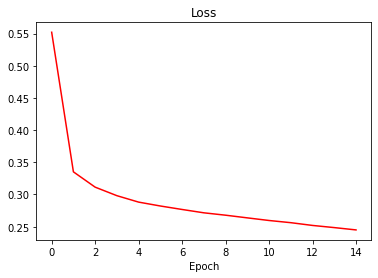

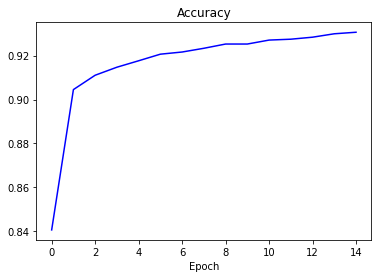

In [18]:
# Train model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
print("Training Model")
# NOTE: Increase the number of epochs if you wish better accuracy
history = model.fit(x_train, y_train, epochs=15)

# Loss plot
plt.plot(history.history["loss"], color='r')
plt.title("Loss")
plt.xlabel("Epoch")
plt.show()

# Accuracy plot
plt.plot(history.history["accuracy"], color='b')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Results
# Training time (15 epochs): ~1 min
# Initial Loss: 0.24
# Initial Accuracy: 0.93

In [19]:
# Evaluate Keras model performance
keras_test_loss, keras_test_acc = model.evaluate(x_test, y_test)

print('Test loss:', keras_test_loss)
print('Test accuracy:', keras_test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.2744 - accuracy: 0.9218
Test loss: 0.2744196951389313
Test accuracy: 0.9218000173568726


In [39]:
# If model was just created, update saved model
# Note: This is using an older model format
model.save('./mnist-model.h5')

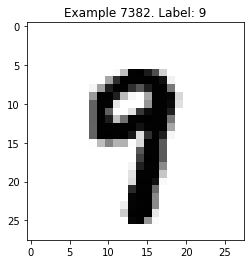

In [21]:
# Show random image via index from test set:
# Plotting data
image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
expected_label = y_test[image_index]
digit_image = x_test[image_index]

# Plot
plt.title('Example %d. Label: %d' % (image_index, expected_label))
plt.imshow(digit_image, cmap='Greys')
plt.show()

In [22]:
# Reshape image for inference/prediction
digit_image = digit_image.reshape(1, imgSize0, imgSize1, 1)

# Repeat to take the average execution time
loop_count = 10

start_time = time.time()
for i in range(loop_count):
    prediction = model.predict(digit_image)
print("Keras inferences with %s second in average" %((time.time() - start_time) / loop_count))

print(prediction)
predicted_label = prediction.argmax()
print('Predicted value:', predicted_label)
if (expected_label == predicted_label):
  print('Correct prediction !')
else:
  print('Wrong prediction !')

Keras inferences with 0.06892364025115967 second in average
[[1.1439949e-08 2.0883925e-07 4.5012609e-08 9.6950034e-04 6.1094388e-02
  9.9643052e-04 3.1785699e-10 3.7724923e-03 3.6835391e-03 9.2948341e-01]]
Predicted value: 9
Correct prediction !


## Conversion from Keras to ONNX

Now we know that the keras model is working, we convert it to ONNX format and re-evaluate the model.

### Result Explanation:
1. Eager_mode: 
2. Converting Operators: 

In [40]:
import keras2onnx
print("keras2onnx Version: "+ keras2onnx.__version__)

# Convert to onnx model
onnx_model = keras2onnx.convert_keras(model, 'mnist-onnx', debug_mode=1)
output_model_path = "./mnist-model.onnx"

# Save the model in ONNX format
keras2onnx.save_model(onnx_model, output_model_path)

tf executing eager_mode: True
INFO:keras2onnx:tf executing eager_mode: True
tf.keras model eager_mode: False
INFO:keras2onnx:tf.keras model eager_mode: False
Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
DEBUG:keras2onnx:Processing a keras layer - (dense_1: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense_1/Identity:0
DEBUG:keras2onnx:	output: dense_1/Identity:0
	input : dense/Identity:0
DEBUG:keras2onnx:	input : dense/Identity:0
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
DEBUG:keras2onnx:Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Identity:0
DEBUG:keras2onnx:	output: dense/Identity:0
	input : flatten/Identity:0
DEBUG:keras2onnx:	input : flatten/Identity:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
DEBUG:keras2onnx:Processing a keras layer - (flatten: <class 'tensorflow.pyt

keras2onnx version is 1.7.0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________
None


## Evaluating ONNX Model Performance (Against Keras Model)

1. Open ONNX Runtime session, providing model path...
2. Define data type to use (float32 is standard and has acceptable precision)
3. 

In [41]:
# Evaluate ONNX Model Performance
import onnxruntime

sess_options = onnxruntime.SessionOptions()
sess = onnxruntime.InferenceSession(output_model_path, sess_options)
data = [digit_image.astype(np.float32)]
input_names = sess.get_inputs()
feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])

In [42]:
start_time = time.time()
for i in range(loop_count):
    onnx_predicted_label = sess.run(None, feed)[0].argmax()
print("ONNX inferences with %s second in average" %((time.time() - start_time) / loop_count))

print('ONNX predicted value:', onnx_predicted_label)
if (expected_label == onnx_predicted_label):
  print('Correct prediction!')
else:
  print('Wrong prediction!')

if (predicted_label == onnx_predicted_label):
  print("The ONNX's and keras' prediction are matching !")
else:
  print("The ONNX's and keras' prediction does not match !")

ONNX inferences with 0.00019958019256591797 second in average
ONNX predicted value: 9
Correct prediction!
The ONNX's and keras' prediction are matching !


## Converting ONNX Model to TensorFlow

1. Load ONNX model
2. Prepare TF representation of model
3. Export model into directory as a .pb file

Simple as that!

**Code Reference:**
https://github.com/onnx/onnx-tensorflow/blob/master/example/onnx_to_tf.py

In [43]:
import onnx
import warnings
from onnx_tf.backend import prepare

warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial

# TODO: make a variable for saved model name

# Load model from current directory
onnx_model = onnx.load("mnist-model.onnx")

# Prepare tensorflow representation
tf_rep = prepare(onnx_model)

# Export model to .pb format
#tf_rep.export_graph("mnist-model.pb")

ValidationError: Nodes in a graph must be topologically sorted, however input 'dense_1/Identity:0' of node: 

dense_1/Identity:0dense_1	Identity5"Identity:

In [14]:
# Print nodes of the model
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

NameError: name 'tf_rep' is not defined